In [137]:
from __future__ import print_function
from builtins import input

import os.path
import tempfile
import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np
import scipy.io as sio

from sporco import util
from sporco import signal
from sporco import plot
plot.config_notebook_plotting()
from sporco.linalg import pca
from sporco.metric import psnr
from sporco.cupy import (cupy_enabled, np2cp, cp2np, select_device_by_load,
                         gpu_info)
from sporco.cupy.admm import pdcsc

In [138]:
def pad(x, n=8):

    if x.ndim == 2:
        return np.pad(x, n, mode='symmetric')
    else:
        return np.pad(x, ((n, n), (n, n), (0, 0)), mode='symmetric')


def crop(x, n=8):

    return x[n:-n, n:-n]

In [139]:
img = util.ExampleImages().image('e.jpg', zoom=0.5, scaled=True,
                                 idxexp=np.s_[:, :])
np.random.seed(12345)
imgn = signal.spnoise(img, 0.44)

In [140]:
D0 = util.convdicts()['G:8x8x32']
Di = np.zeros(D0.shape[0:2] + (1,), dtype=np.float32)
Di[0, 0] = 1.0
D = np.concatenate((Di, D0), axis=2)

S = img.reshape((-1, img.shape[-1])).T
pcaB, pcaS, pcaC = pca(S, centre=False)
B = pcaB[:, 0:20]

In [141]:
lmbda = 4.2e0
mu = 9.5e0

In [142]:
wl1 = np.ones((1,)*4 + (D.shape[2],), dtype=np.float32)
wl1[..., 0] = 0.0

In [143]:
wgr = np.zeros((D.shape[2]), dtype=np.float32)
wgr[0] = 1.0

In [144]:
opt = pdcsc.ConvProdDictL1L1GrdJoint.Options(
    {'Verbose': True, 'MaxMainIter': 100, 'RelStopTol': 5e-3,
     'AuxVarObj': False, 'rho': 1e1, 'RelaxParam': 1.8,
     'L21Weight': np2cp(wl1), 'GradWeight': np2cp(wgr)})

In [145]:
if not cupy_enabled():
    print('CuPy/GPU device not available: running without GPU acceleration\n')
else:
    id = select_device_by_load()
    info = gpu_info()
    if info:
        print('Running on GPU %d (%s)\n' % (id, info[id].name))

b = pdcsc.ConvProdDictL1L1GrdJoint(np2cp(D), np2cp(B), np2cp(pad(imgn)),
                              lmbda, mu, opt=opt, dimK=0)
X = cp2np(b.solve())

CuPy/GPU device not available: running without GPU acceleration

Itn   Fnc       DFid      Regℓ21    Regℓ2∇    r         s       
----------------------------------------------------------------
   0  3.35e+05  3.83e+04  7.05e+04  6.01e+01  3.47e-01  1.19e+00
   1  2.73e+05  3.94e+04  5.51e+04  1.87e+02  2.06e-01  1.01e+00
   2  2.23e+05  3.74e+04  4.37e+04  2.54e+02  1.67e-01  8.76e-01
   3  1.81e+05  4.51e+04  3.16e+04  3.12e+02  1.29e-01  6.26e-01
   4  1.70e+05  4.98e+04  2.78e+04  3.24e+02  1.12e-01  5.85e-01
   5  1.63e+05  5.37e+04  2.53e+04  3.19e+02  1.02e-01  5.09e-01
   6  1.59e+05  5.62e+04  2.38e+04  3.14e+02  9.35e-02  4.89e-01
   7  1.51e+05  5.76e+04  2.15e+04  3.09e+02  8.61e-02  5.07e-01
   8  1.41e+05  5.81e+04  1.92e+04  3.06e+02  7.93e-02  5.15e-01
   9  1.33e+05  5.81e+04  1.73e+04  3.03e+02  7.33e-02  4.91e-01
  10  1.28e+05  5.79e+04  1.61e+04  3.01e+02  6.81e-02  4.86e-01
  11  1.26e+05  5.79e+04  1.56e+04  2.96e+02  6.29e-02  4.66e-01
  12  1.23e+05  5.79e+04 

In [146]:
imgdp = cp2np(b.reconstruct().squeeze())
imgd = crop(imgdp)

In [147]:
print("ConvProdDictL1L1GrdJoint solve time: %5.2f s" % b.timer.elapsed('solve'))
print("Noisy image PSNR:    %5.2f dB" % psnr(img, imgn))
print("Denoised image PSNR: %5.2f dB" % psnr(img, imgd))

ConvProdDictL1L1GrdJoint solve time: 4799.21 s
Noisy image PSNR:     7.69 dB
Denoised image PSNR: 29.07 dB


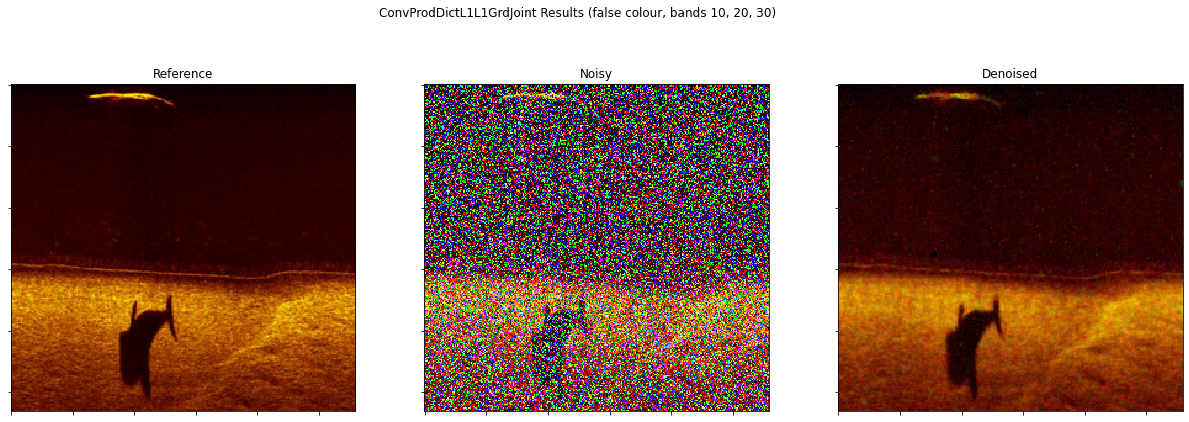

In [148]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(21, 7))
fig.suptitle('ConvProdDictL1L1GrdJoint Results (false colour, '
             'bands 10, 20, 30)')
plot.imview(img, title='Reference', ax=ax[0], fig=fig)
plot.imview(imgn, title='Noisy', ax=ax[1], fig=fig)
plot.imview(imgd, title='Denoised', ax=ax[2], fig=fig)
fig.show()


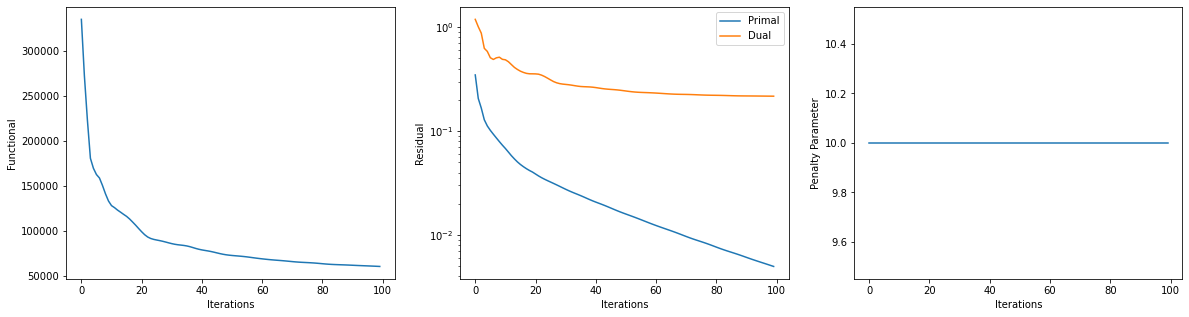

In [149]:
its = b.getitstat()
ObjFun = [float(x) for x in its.ObjFun]
PrimalRsdl = [float(x) for x in its.PrimalRsdl]
DualRsdl = [float(x) for x in its.DualRsdl]
fig = plot.figure(figsize=(20, 5))
plot.subplot(1, 3, 1)
plot.plot(ObjFun, xlbl='Iterations', ylbl='Functional', fig=fig)
plot.subplot(1, 3, 2)
plot.plot(np.vstack((PrimalRsdl, DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'], fig=fig)
plot.subplot(1, 3, 3)
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter', fig=fig)
fig.show()

In [150]:
from skimage.metrics import structural_similarity as ssim
ssim_const_1 = ssim(img, imgd,
                  data_range=imgd.max() - imgd.min(), multichannel=True)

print(ssim_const_1)#structure similarity between two random variables -it measures contrast,variance,mean, luminous,covariance 

0.6716282681199864
